# Bodily signals & MEG

In [1]:
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [26]:
datapath = "/Users/b1019548/Library/CloudStorage/OneDrive-UniversitätSalzburg/Teaching/Master_VO_MethodsCogNeuro/Lecture7_Interoception/data/20010321anae_rest_trans_sss.fif"

#ECG: ECG003; Breathing: MISC001
raw = mne.io.read_raw_fif(datapath, preload=True)
#info = mne.io.read_info("sample-info.fif", verbose = True)
#info = mne.Info(info, sfreq=100)

Opening raw data file /Users/b1019548/Library/CloudStorage/OneDrive-UniversitätSalzburg/Teaching/Master_VO_MethodsCogNeuro/Lecture7_Interoception/data/20010321anae_rest_trans_sss.fif...
    Range : 10000 ... 311999 =     10.000 ...   311.999 secs
Ready.
Reading 0 ... 301999  =      0.000 ...   301.999 secs...


/var/folders/hq/25wkh5ks4x3bl8rfsmsnt_vw2w8qk_/T/ipykernel_94299/993587889.py:4: RuntimeWarning: This filename (/Users/b1019548/Library/CloudStorage/OneDrive-UniversitätSalzburg/Teaching/Master_VO_MethodsCogNeuro/Lecture7_Interoception/data/20010321anae_rest_trans_sss.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datapath, preload=True)


In [27]:
#Spectrum ECG, breathing
psd_ecg = raw.copy().compute_psd(picks="ecg", fmin = 0, fmax = 10)
psd_breath = raw.copy().compute_psd(picks="misc", fmin = 0, fmax = 10)

Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


Peak Freqeuency Breathing:  0.48828125 Hz
Peak Freqeuency Breathing:  0.9765625 Hz


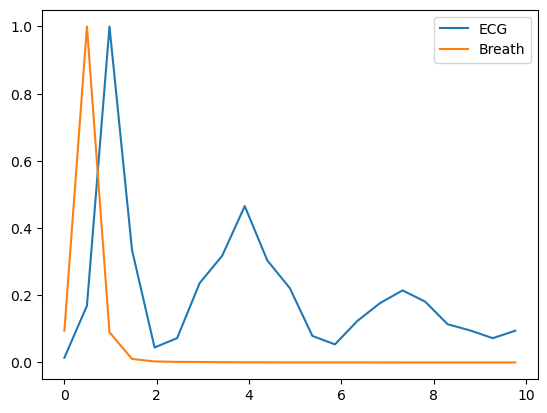

In [28]:
plt.plot(psd_ecg.freqs, np.transpose(psd_ecg._data)/np.max(psd_ecg._data))
plt.plot(psd_ecg.freqs, np.transpose(psd_breath._data)/np.max(psd_breath._data))
plt.legend(['ECG', 'Breath'])

print("Peak Freqeuency Breathing: ", psd_breath.freqs[np.argmax(psd_breath._data)], "Hz")
print("Peak Freqeuency Breathing: ", psd_ecg.freqs[np.argmax(psd_ecg._data)], "Hz")


No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 1651 samples (1.651 s)



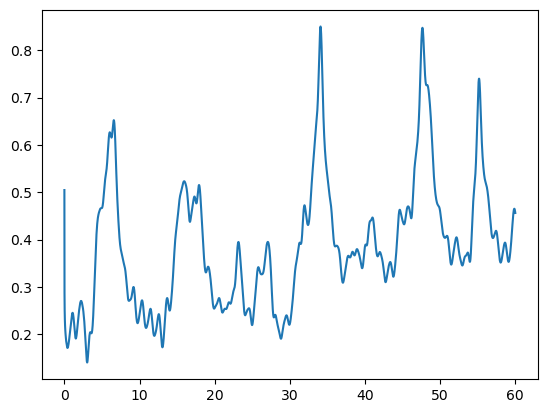

In [81]:
#low_breath_raw = raw.copy().pick(picks="misc").filter(l_freq = None, h_freq = 1).apply_hilbert()
low_breath_raw = raw.copy().pick("misc")
low_breath_raw.filter(picks='all', l_freq=None, h_freq=1).apply_hilbert(picks='all');

low_breath_angle = np.angle(low_breath_raw.get_data())

durpoints = int(60 * low_breath_raw.info['sfreq'])
plt.plot(low_breath_raw.times[:durpoints], np.abs(low_breath_raw.get_data()[0,:durpoints])) #plot envelope

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Filter length: 1651 samples (1.651 s)



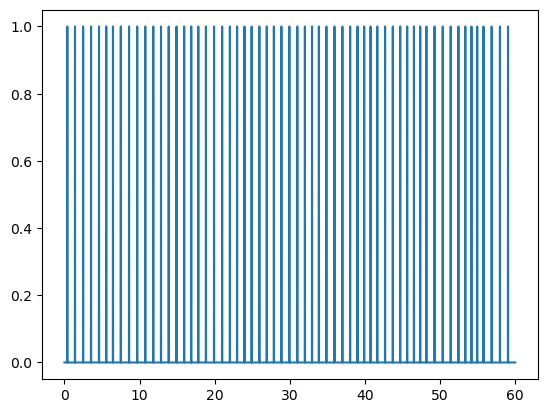

In [103]:
ecg_raw = raw.copy().pick("ecg")
ecg_raw.filter(picks='all', l_freq=2, h_freq=None)

ecg_data = np.abs(ecg_raw.get_data())
ecg_thresh = ecg_data > 0.0015 #visual inspection threshols

#plt.plot(ecg_raw.times[:durpoints], ecg_raw.get_data()[0,:durpoints]) #plot envelope
plt.plot(ecg_raw.times[:durpoints], ecg_thresh[0,:durpoints]) #plot envelope

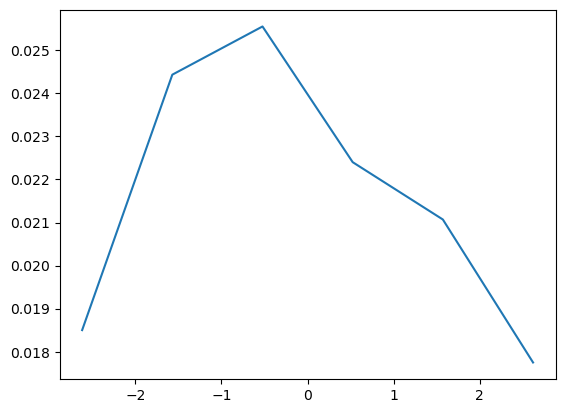

In [126]:
def bin_and_prob(low_breath_angle, ecg_thresh, num_bins=10):
    """
    Bins low_breath_angle into num_bins and calculates the probability of 1s in ecg_thresh within each bin
    
    Args:
    low_breath_angle: numpy array of shape (n_samples, )
    ecg_thresh: numpy array of shape (n_samples, )
    num_bins: int, number of bins to divide the data into
    
    Returns:
    bin_edges: numpy array of shape (num_bins+1, ), edges of the bins
    bin_probs: numpy array of shape (num_bins, ), probability of 1s in ecg_thresh within each bin
    """
    bin_edges = np.linspace(-np.pi, np.pi, num_bins+1)
    bin_probs = []
    for i in range(num_bins):
        bin_low_breath = low_breath_angle[(low_breath_angle >= bin_edges[i]) & (low_breath_angle < bin_edges[i+1])]
        bin_ecg = ecg_thresh[(low_breath_angle >= bin_edges[i]) & (low_breath_angle < bin_edges[i+1])]
        bin_probs.append(np.mean(bin_ecg))
    
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return bin_centers, bin_probs

bin_centers, bin_probs = bin_and_prob(low_breath_angle, ecg_thresh, num_bins=6)
plt.plot(bin_centers, bin_probs)

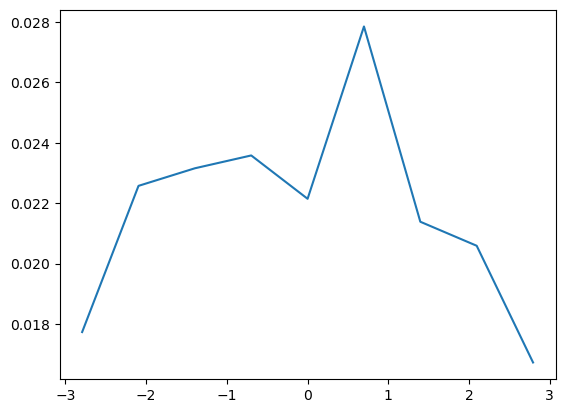

In [ ]:
# GET EVENTS ECG
# FFT BREATHING

## calculate ICA

HEART EVOKED RESPONSE ... WITH AND WITHOUT ICA